In [ ]:
# 구글 드라이브의 폴더와 구글 코랩 폴더 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 현재 경로 확인
!pwd

/content/drive/My Drive/Colab Notebooks


In [ ]:
# drive/My Drive/Colab Notebooks 경로로 변경
%cd drive/My\ Drive/Colab\ Notebooks\

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks'
/content/drive/My Drive/Colab Notebooks


# Object Detection 

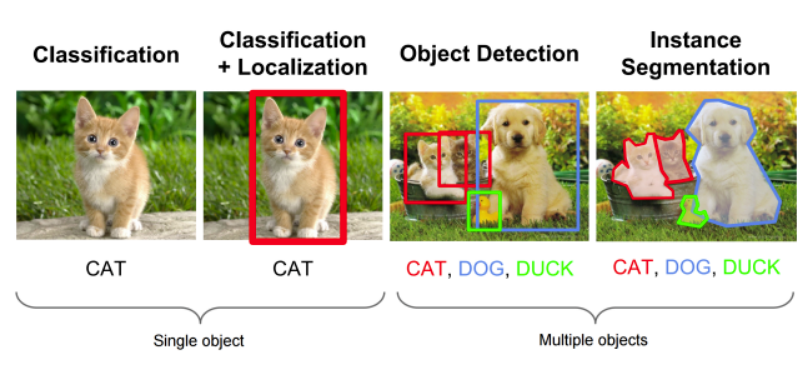

```
Single object detection 문제는 학습 데이터 구성을 하나의 물체로만 구성된 이미지들로 학습을 하게 되면 어렵지 않게 구현할 수 있다 
하지만, Multiple object detection 문제는 물체가 한 개일 때 두 개 일 때 등 몇 개인지 정해지지 않았을 때는 문제가 까다로워진다 

결국 이러한 문제를 해결하기 위해 고안된 방식이 Region proposal인 것이다 
Localization이후에 detection을 하게 되면 multiple object detection 문제도 어느 정도 해결이 가능해 진다 
```

## Faster R-CNN

> Fast R-CNN은 하나의 네트워크로 구성할 수 없기 때문에 병목 현상이 발생하는 문제가 있었다 <br>
> 이러한 문제점을 보완하여 Selective search대신 Region proposal을 네트워크로 만들어 속도를 향상시킨 모델이다 

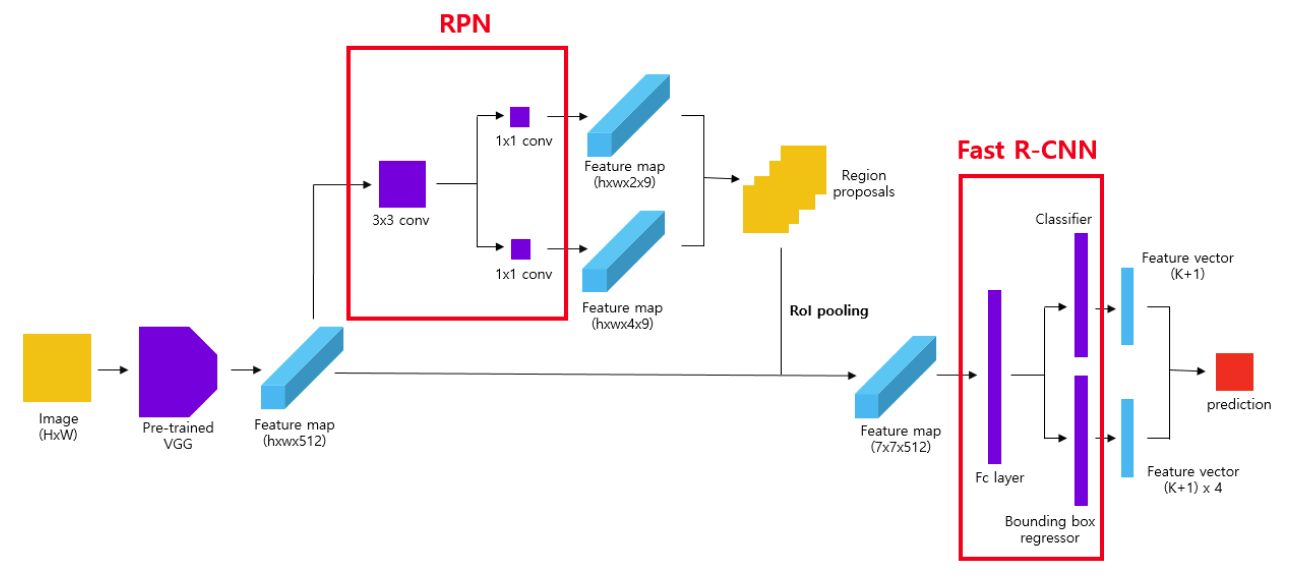

```python
Region proposal 구하는 과정 

1. Pre-trained VGG모델에 이미지를 입력값으로 넣는다 
2. VGG모델로 부터 나온 feature map을 3x3 conv연산을 한다 
3. class score를 매기기 위해서 feature map에 대하여 1x1 conv 연산을 한다
4. class score에 따라 상위 N개의 region proposals만을 추출한다 
```

In [1]:
import tensorflow as tf 
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as pt

In [2]:
img = tf.keras.utils.get_file('zebra.jpg', 'https://i.imgur.com/XjeiRMV.jpg')

In [3]:
h = w = 800

im = cv2.imread(img)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

im_r = cv2.resize(im, (h,w))
im_r_ = im_r.copy()

In [4]:
vgg = tf.keras.applications.VGG16(include_top=False)
backbone = tf.keras.models.Model(vgg.input, vgg.layers[17].output) 

58900480/58889256 [==============================] - 1s 0us/step


In [17]:
backbone(im_r_[tf.newaxis]).shape

TensorShape([1, 50, 50, 512])

In [20]:
backbone(im_r_[tf.newaxis])[0,...,0].shape

TensorShape([50, 50])

In [21]:
backbone(im_r_[tf.newaxis])[0,...,0]

<tf.Tensor: shape=(50, 50), dtype=float32, numpy=
array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 1.2889676, 15.054933 , 11.117959 , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)>

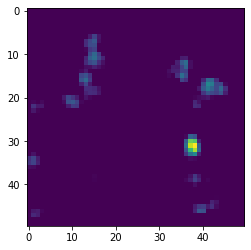

In [24]:
plt.imshow(backbone(im_r_[tf.newaxis])[0,...,0]) # 원본 이미지가 vgg네트워크를 통과하면 원본이미지의 16x16크기가 feature map의 1x1로 표현된다 

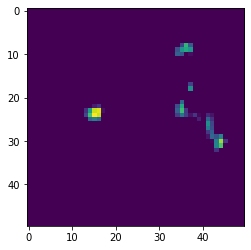

In [25]:
plt.imshow(backbone(im_r_[tf.newaxis])[0,...,1])

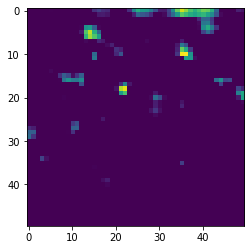

In [26]:
plt.imshow(backbone(im_r_[tf.newaxis])[0,...,2])

## IOU 계산 

In [4]:
box1 = [20,50,200,200]
box2 = [220,220,440,440]

In [5]:
x = np.zeros((500,500))

In [6]:
def iou(box1, box2):
  x1 = max(box1[0], box2[0])
  y1 = max(box1[1], box2[1])

  x2 = min(box1[2], box2[2])
  y2 = min(box1[3], box2[3])

  if (x1 < x2 and y1 < y2):
    w_o = x2-x1 
    h_o = y2-y1 
    area =  w_o*h_o
  else:
    return 0
  
  area_b1 = (box1[2] - box1[0])*(box1[3] - box1[1])
  area_b2 = (box2[2] - box2[0])*(box2[3] - box2[1])
  union =  area_b1 + area_b2 - area

  return area/union

In [7]:
iou(box1, box2)

0

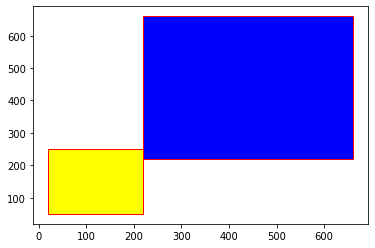

In [8]:
fig, ax = plt.subplots()
ax.plot()
ax.add_patch(
   pt.Rectangle(
      (box1[0], box1[1]),                   
      box1[2], box1[3],                     
      edgecolor = 'red',
      facecolor = 'yellow',
      fill=True,
   ))
ax.add_patch(
   pt.Rectangle(
      (box2[0], box2[1]),                   
      box2[2], box2[3],                     
      edgecolor = 'red',
      facecolor = 'blue',
      fill=True,
   ))
plt.show()

In [9]:
x = np.arange(8,800,16)
y = np.arange(8,800,16)
ratio = [0.5,1,2]
scale = [8,16,32]
al = np.zeros((22500,4)) 
count = 0
cl = np.array(np.meshgrid(x,y)).T.reshape(-1,2) 

for i in cl:
  cx, cy = i[0], i[1]
  for r in ratio:
    for s in scale:
      h = pow(pow(s,2)/r,0.5) 
      w = h*r
      h *= 16 
      w *= 16 
      xmin = cx-0.5*w
      ymin = cy-0.5*h
      xmax = cx+0.5*w
      ymax = cy+0.5*h
      al[count] = [xmin,ymin,xmax,ymax]
      count += 1 

### Anchor는 0보다 작고 800보다 큰 값은 제외 시키고 구한다 

In [10]:
is_al = al[np.where((al[:,0]>=0) & (al[:,1]>=0) & (al[:,2]<=800) & (al[:,3]<=800))]

In [11]:
len(is_al)

8940

In [12]:
im.shape, im_r_.shape

((333, 500, 3), (800, 800, 3))

In [13]:
box1 = [120,25,200,165]
box2 = [300,50,480,320]

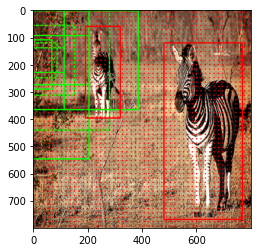

In [14]:
point = 550
h = w = 800

x = np.array([120,25,200,165])
y = np.array([300,50,480,320])


img_ = np.copy(im_r_)
for i in range(point,point+9):
  x_min = int(al[i][0])
  y_min = int(al[i][1])
  x_max = int(al[i][2])
  y_max = int(al[i][3])
  cv2.rectangle(img_, (x_min,y_min),(x_max,y_max),(0,255,0),thickness=4)

for i in range(2500):
  cv2.circle(img_, (cl[i,0],cl[i,1]), 1, (255,0,0), thickness=2)

x[0] = int(x[0]*(w/im.shape[1])) 
x[1] = int(x[1]*(h/im.shape[0]))
x[2] = int(x[2]*(w/im.shape[1]))
x[3] = int(x[3]*(h/im.shape[0]))

y[0] = int(y[0]*(w/im.shape[1]))
y[1] = int(y[1]*(h/im.shape[0]))
y[2] = int(y[2]*(w/im.shape[1]))
y[3] = int(y[3]*(h/im.shape[0]))

rec1 = cv2.rectangle(img_, (x[0],x[1]),(x[2],x[3]), color=(255,0,0), thickness=3)
rec2 = cv2.rectangle(img_, (y[0],y[1]),(y[2],y[3]), color=(255,0,0), thickness=3)

plt.imshow(img_)

In [41]:
x # object 1

array([192,  60, 320, 396])

In [42]:
y # object2

array([480, 120, 768, 768])

In [55]:
objects = [x,y]
result = np.zeros((8940,len(objects)))

for t, g in enumerate(objects):
  for i,j in enumerate(is_al):
    result[i][t] = iou(j,g)

anchor_id = np.where((al[:,0]>=0) & (al[:,1]>=0) & (al[:,2]<=800) & (al[:,3]<=800))

data = pd.DataFrame(data=[anchor_id[0],result[:,0],result[:,1]]).T # anchor당 iou값 
data.rename(columns={0:'anchor_id',1:'o1_iou',2:'o2_iou'}, inplace=True)
data.anchor_id = data.anchor_id.astype('int')

In [56]:
data

,anchor_id,o1_iou,o2_iou
0,1404,0.0,0.000000
1,1413,0.0,0.000000
2,1422,0.0,0.000000
3,1431,0.0,0.000000
4,1440,0.0,0.000000
...,...,...,...
8935,21051,0.0,0.065818
8936,21060,0.0,0.065818
8937,21069,0.0,0.065818
8938,21078,0.0,0.064846


In [57]:
data.o1_iou.max(), data.o1_iou.argmax()

(0.6562500000000001, 1785)

In [58]:
data.o2_iou.max(), data.o2_iou.argmax()

(0.7119140625000001, 7540)

In [63]:
data[data.o1_iou > 0.65]

,anchor_id,o1_iou,o2_iou
1785,6418,0.65625,0.0
1791,6427,0.65625,0.0
2013,6868,0.65625,0.0
2019,6877,0.65625,0.0
2241,7318,0.65625,0.0
2247,7327,0.65625,0.0
2487,7768,0.65625,0.0
2493,7777,0.65625,0.0


In [61]:
data[data.o2_iou > 0.7]

,anchor_id,o1_iou,o2_iou
7540,16877,0.0,0.711914
7547,16886,0.0,0.711914
7768,17327,0.0,0.711914
7775,17336,0.0,0.711914


In [65]:
data[data.o2_iou > 0.7].anchor_id.values, 1785 # 5개만 물체라고 볼수 있다 

(array([16877, 16886, 17327, 17336]), 1785)

In [68]:
top = al[data[data.o2_iou > 0.7].anchor_id.values]

In [67]:
al[1785]

array([ -8., 712., 120., 840.])

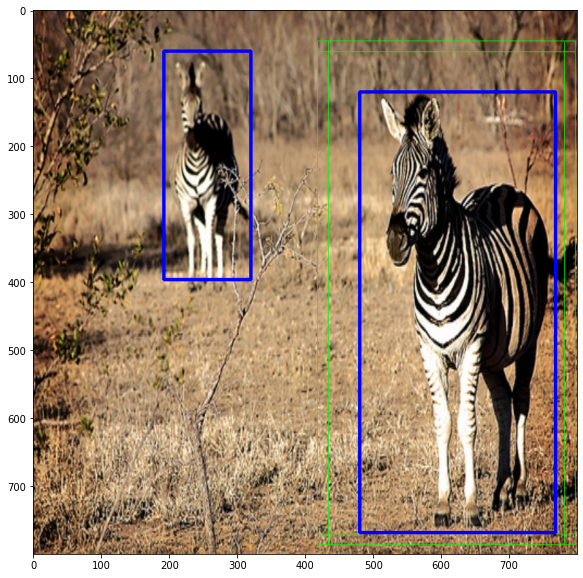

In [72]:
point = 550
h = w = 800

x = np.array([120,25,200,165])
y = np.array([300,50,480,320])


img_2 = np.copy(im_r_)
for i,j in enumerate(top):
  x_min = int(top[i][0])
  y_min = int(top[i][1])
  x_max = int(top[i][2])
  y_max = int(top[i][3])
  cv2.rectangle(img_2, (x_min,y_min),(x_max,y_max),(0,255,0),thickness=1)

# for i in range(2500):
#   cv2.circle(img_2, (cl[i,0],cl[i,1]), 1, (255,0,0), thickness=2)

x[0] = int(x[0]*(w/im.shape[1])) 
x[1] = int(x[1]*(h/im.shape[0]))
x[2] = int(x[2]*(w/im.shape[1]))
x[3] = int(x[3]*(h/im.shape[0]))

y[0] = int(y[0]*(w/im.shape[1]))
y[1] = int(y[1]*(h/im.shape[0]))
y[2] = int(y[2]*(w/im.shape[1]))
y[3] = int(y[3]*(h/im.shape[0]))

rec1 = cv2.rectangle(img_2, (x[0],x[1]),(x[2],x[3]), color=(0,0,255), thickness=3)
rec2 = cv2.rectangle(img_2, (y[0],y[1]),(y[2],y[3]), color=(0,0,255), thickness=3)

plt.figure(figsize=(10,10))
plt.imshow(img_2)

In [74]:
data['o1_iou_objectness'] = data.apply(lambda x: 1 if x['o1_iou'] > 0.7 else -1, axis=1)

In [76]:
data['o2_iou_objectness'] = data.apply(lambda x: 1 if x['o2_iou'] > 0.7 else -1, axis=1)

In [75]:
data[data['o1_iou_objectness']==1]

,anchor_id,o1_iou,o2_iou,o1_iou_objectness


In [77]:
data[data['o2_iou_objectness']==1]

,anchor_id,o1_iou,o2_iou,o1_iou_objectness,o2_iou_objectness
7540,16877,0.0,0.711914,-1,1
7547,16886,0.0,0.711914,-1,1
7768,17327,0.0,0.711914,-1,1
7775,17336,0.0,0.711914,-1,1


## Region proposal

In [82]:
input_ = tf.keras.Input((50,50,512))
x = tf.keras.layers.Conv2D(512,3, padding='same')(input_)
regressor = tf.keras.layers.Conv2D(4*9,1, activation='linear', name='reg')(x)
classifier = tf.keras.layers.Conv2D(9,1, activation='sigmoid', name='cla')(x)
PRN = tf.keras.models.Model(input_, [regressor, classifier])

In [83]:
PRN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 50, 512) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 50, 50, 512)  2359808     input_2[0][0]                    
__________________________________________________________________________________________________
reg (Conv2D)                    (None, 50, 50, 36)   18468       conv2d_2[0][0]                   
__________________________________________________________________________________________________
cla (Conv2D)                    (None, 50, 50, 9)    4617        conv2d_2[0][0]                   
Total params: 2,382,893
Trainable params: 2,382,893
Non-trainable params: 0
__________________

## Loss 

In [90]:
y_true = np.array([[0.,1.],[0.,0.]])
y_pred = np.array([[1.,1.],[1.,0.]])

In [91]:
loss1 = tf.keras.losses.MeanSquaredError()
loss2 = tf.keras.losses.mean_squared_error

In [92]:
tf.nn.l2_loss(y_true-y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=1.0>

In [94]:
loss1(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.5>

In [96]:
loss2(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.5, 0.5])>

In [86]:
loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [109]:
def smooth_l1_loss(y_truee, y_pred,smooth=1):
  x = tf.abs(y_true, y_pred)
  mask = tf.cast(tf.less(x,1.0), tf.float32)
  loss = (mask*(0.5*x**2)) + (1-mask)*(x-0.5)
  return loss  

In [110]:
class MyLoss(tf.keras.losses.Loss):
  def call(self,y_true,y_pred,smooth=1):
    x = tf.abs(y_true, y_pred)
    mask = tf.cast(tf.less(x,1.0), tf.float32)
    loss = (mask*(0.5*x**2)) + (1-mask)*(smooth-0.5)
    return loss


In [111]:
from functools import partial

In [112]:
mys = partial(smooth_l1_loss, smooth=2)